In [ ]:
import sys
module_path = r"../src"
sys.oath.append(module_path)

import os
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from vis.confusion_matrix import plot_cm
from pathlib import Path
from dataclasses import dataclass
from joblib import Parallel, delayed
from tqdm import tqdm
import pickle


/Users/tqh7876/Library/CloudStorage/OneDrive-Takeda/ActiveProjects/WearableSimulations/code/quantitative-sciences-nt1-detection-wearable-simulation


In [ ]:
@dataclass
class MCMC_Dataset:
    version: str
    name: str
    dx: str
    data_source: str
    num_recordings: str
    transition_matrix: np.ndarray
    dataset: str = ''
    savedir: Path = Path('./export')

    def __post_init__(self):
        self.dataset = self.name if not self.dataset else self.dataset
        self.savedir = Path(savedir) / version
        self.tm = np.array(self.transition_matrix) if not isinstance(self.transition_matrix, np.ndarray) else self.transition_matrix
        self.experiment_name = f'{self.name}_Dx-{self.dx}_Data-{self.dataset}_Recs-{self.num_recordings}'
        self.num_samples = self.tm.sum() if self.num_recordings == 2 else self.tm.sum() // 2

    def get_transition_matrix(self, plot=False):
        if plot:
            self.plot_matrix(self.tm, matrix_type='tm')

    def get_transition_matrix_normalized(self, plot=False):
        tm_norm = self.tm / self.tm.sum(axis=1, keepdims=True)
        if plot:
            self.plot_matrix(tm_norm, matrix_type='tm_norm', decimals=3)
        return tm_norm

    def get_initial_distribution_normalized(self, plot=False):
        id_norm = self.tm.sum(axis=0) / self.tm.sum()
        if plot:
            self.plot_matrix(id_norm[np.newaxis, :], matrix_type='id_norm', decimals=3, ylabel='Initial Distribution')
        return id_norm

    def _single_chain_run(self, initial_distribution, transition_matrix, N, choices):
        counts_single = np.zeros(N, dtype=int)
        current_state = np.random.choice(choices, p=initial_distribution)
        for n in range(N):
            counts_single[n] = current_state
            current_state = np.random.choice(choices, p=transition_matrix[current_state])
        return counts_single

    def run_MCMC(self, R: int, N: int, n_jobs=-1, overwrite=False):
        
        # path stuff
        savedir_mcmc = self.savedir / 'mcmc'
        os.makedirs(savedir_mcmc, exist_ok=True)
        fp_mcmc = savedir_mcmc / f"{self.experiment_name}_{R}.pkl" # adding realizations to name

        if fp_mcmc.exists() and not overwrite:
            with open(fp_mcmc, 'rb') as f:
                mcmc_results = pickle.load(f)
                print(f"Loaded existing MCMC results. {fp_mcmc}")
                return mcmc_results
        
        initial_distribution = self.get_initial_distribution_normalized()
        transition_matrix = self.get_transition_matrix_normalized()
        num_choices = transition_matrix.shape[0]
        choices = list(range(num_choices))
        
        parallel_results = Parallel(n_jobs=n_jobs)(
            delayed(self._single_chain_run)(initial_distribution, transition_matrix, N, choices)
            for _ in tqdm(range(R), desc="Processing MCMC in parallel")
        )
        
        mcmc_results = np.array(parallel_results)
        with open(fp_mcmc, 'wb') as f:
            pickle.dump(mcmc_results, f)
        print("Saved MCMC results.")
        return mcmc_results
    
    def get_config_dict(self):
        return {
            'Experiment': self.experiment_name,
            'name': self.name,
            'Dx': self.dx,
            'num samples': self.num_samples,
            'data source': self.data_source,
            'dataset': self.dataset,
            'recordings (#)': self.num_recordings,
        }

    def plot_matrix(self, x, events=['-', '+'], ylabel='Test 1', xlabel='Test 2', decimals=0, matrix_type='tm'):

        # title
        title = f"{self.name}"
        title += f"\n{self.data_source}, {self.num_recordings} rec" if self.num_recordings == 1 else f"\n{self.data_source}, {self.num_recordings} recs"
        title += f"\n{self.dx} (n={self.num_samples})"
        
        # plot
        plot_cm(x, events=events, 
                marginals=False, decimals=decimals, decimals_marg=3,
                title=title, xlabel=xlabel, ylabel=ylabel, 
                figsize=(1.5, 1.5), fontsize=6)
        
        # save plot
        savedir = self.savedir / matrix_type
        os.makedirs(savedir, exist_ok=True)
        plt.savefig(savedir / f"{self.experiment_name}.png", dpi=300, bbox_inches="tight")
    
    def plot_histogram(self, data, x, hue=None, hue_order=None, binwidth=1, kde=True, kde_kws={'bw_adjust': 8}):
        
        # helpers
        title = f"{self.name}\n{self.data_source}, {self.num_recordings} rec(s)\n{self.dx} (n={self.num_samples})"
        kwargs = {'bins': range(0, 2)} if len(data[x].unique()) == 1 else {'binwidth': 1}
        savedir = self.savedir / 'mcmc_hist'
        os.makedirs(savedir, exist_ok=True)

        # plot
        fig, ax = plt.subplots(nrows=1, figsize=(3.5, 3))
        sns.histplot(data, x=x, hue=hue, hue_order=hue_order, kde=kde, kde_kws=kde_kws, ax=ax, **kwargs)
        ax.set_title(title)
        # ax.set_xlim([0, nights])
        # save
        fig.savefig(savedir / f"{self.experiment_name}.png", dpi=300, bbox_inches="tight")
    
    

In [ ]:
datasets = [
    # Single night - stanford
    # ----------------
    # PSG only
    # {'name': 'NT1 detector - PSG', 'dx': 'NT1', 'dataset': 'Stanford - test', 'data_source': 'nPSG', 'num_recordings': 1, 'transition_matrix': [[37, 280], [37, 280]]},
    # {'name': 'NT1 detector - PSG', 'dx': 'Con', 'dataset': 'Stanford - test', 'data_source': 'nPSG', 'num_recordings': 1, 'transition_matrix': [[316, 1], [316, 1]]},
    # Wearable - simulated
    #{'name': 'Wearable simulated', 'dx': 'NT1', 'dataset': 'Stanford - test', 'data_source': 'nPSG - hypnogram', 'num_recordings': 1, 'transition_matrix': [[153, 164], [153, 164]]},
    #{'name': 'Wearable simulated', 'dx': 'Con', 'dataset': 'Stanford - test', 'data_source': 'nPSG - hypnogram', 'num_recordings': 1, 'transition_matrix': [[312, 5], [312, 5]]},
    
    # Single night - Stanford All
    {'name': 'Wearable simulated', 'dx': 'NT1', 'dataset': 'first night (test)', 'data_source': 'nPSG - hypnogram', 'num_recordings': 1, 'transition_matrix': [[61, 90], [61, 90]]},
    {'name': 'Wearable simulated', 'dx': 'Con', 'dataset': 'first night (test)', 'data_source': 'nPSG - hypnogram', 'num_recordings': 1, 'transition_matrix': [[4854, 48], [4854, 48]]},
    {'name': 'SOREMP positive', 'dx': 'NT1', 'dataset': 'first night (test)', 'data_source': 'nPSG - hypnogram', 'num_recordings': 1, 'transition_matrix': [[62, 89], [62, 89]]},
    {'name': 'SOREMP positive', 'dx': 'Con', 'dataset': 'first night (test)', 'data_source': 'nPSG - hypnogram', 'num_recordings': 1, 'transition_matrix': [[4820, 82], [4820, 82]]},
    
    # Dual night - all
    {'name': 'Wearable simulated', 'dx': 'NT1', 'dataset': 'dual nights (test)', 'data_source': 'nPSG - hypnogram', 'num_recordings': 2, 'transition_matrix': [[13, 6], [1, 8]]},
    {'name': 'Wearable simulated', 'dx': 'Con', 'dataset': 'dual nights (test)', 'data_source': 'nPSG - hypnogram', 'num_recordings': 2, 'transition_matrix': [[4632, 55], [41, 4]]},
    {'name': 'SOREMP positive', 'dx': 'NT1', 'dataset': 'dual nights (test)', 'data_source': 'nPSG - hypnogram', 'num_recordings': 2, 'transition_matrix': [[16, 3], [4, 5]]},
    {'name': 'SOREMP positive', 'dx': 'Con', 'dataset': 'dual nights (test)', 'data_source': 'nPSG - hypnogram', 'num_recordings': 2, 'transition_matrix': [[4580, 72], [76, 4]]},
    
    # Dual nights - colapsed
    {'name': 'Multi-feature', 'dx': 'NT1', 'dataset': 'dual nights - colapsed (test)', 'data_source': 'nPSG - hypnogram', 'num_recordings': 1, 'transition_matrix': [[19, 9], [19, 9]]},
    {'name': 'Multi-feature', 'dx': 'Con', 'dataset': 'dual nights - colapsed (test)', 'data_source': 'nPSG - hypnogram', 'num_recordings': 1, 'transition_matrix': [[4687, 45], [4687, 45]]},
    {'name': 'SOREMP positive', 'dx': 'NT1', 'dataset': 'dual nights - colapsed (test)', 'data_source': 'nPSG - hypnogram', 'num_recordings': 1, 'transition_matrix': [[19, 9], [19, 9]]},
    {'name': 'SOREMP positive', 'dx': 'Con', 'dataset': 'dual nights - colapsed (test)', 'data_source': 'nPSG - hypnogram', 'num_recordings': 1, 'transition_matrix': [[4652, 80], [4652, 80]]},
    

    # MSLT
    # ----------------
    # Torstensen et al. (2023)
    {'name': 'Torstensen et al. (2023)', 'dx': 'NT1', 'data_source': 'MSLT', 'num_recordings': 2, 'transition_matrix': [[6, 3], [3, 13]]}, 
    {'name': 'Torstensen et al. (2023)', 'dx': 'DoH', 'data_source': 'MSLT', 'num_recordings': 2, 'transition_matrix': [[74, 4], [15, 7]]}, 
    # Lopez et al. (2017)
    {'name': 'Lopez et al. (2017)', 'dx': 'NT1', 'data_source': 'MSLT', 'num_recordings': 2, 'transition_matrix': [[4, 2], [3, 13]]}, 
    {'name': 'Lopez et al. (2017)', 'dx': 'DoH', 'data_source': 'MSLT', 'num_recordings': 2, 'transition_matrix': [[47, 11], [9, 8]]}, 
    # Ruoff et al. (2018)
    {'name': 'Ruoff et al. (2018)', 'dx': 'NT1', 'data_source': 'MSLT', 'num_recordings': 2, 'transition_matrix': [[0, 6], [3, 31]]},
    {'name': 'Ruoff et al. (2018)', 'dx': 'NT2', 'data_source': 'MSLT', 'num_recordings': 2, 'transition_matrix': [[0, 20], [12, 7]]},
    {'name': 'Ruoff et al. (2018)', 'dx': 'Con', 'data_source': 'MSLT', 'num_recordings': 2, 'transition_matrix': [[0, 2], [12, 1]]},
    # Trotti et al. (2013)
    {'name': 'Trotti et al. (2013)', 'dx': 'DoH', 'data_source': 'MSLT', 'num_recordings': 2, 'transition_matrix': [[19, 2], [10, 5]]},
    # MSLT combined
    {'name': 'MSLT combined', 'dx': 'NT1', 'data_source': 'MSLT', 'num_recordings': 2, 'transition_matrix': [[10, 11], [9, 47]]},
    {'name': 'MSLT combined', 'dx': 'DoH', 'data_source': 'MSLT', 'num_recordings': 2, 'transition_matrix': [[140, 37], [46, 27]]},
    {'name': 'MSLT combined', 'dx': 'Con', 'data_source': 'MSLT', 'num_recordings': 2, 'transition_matrix': [[0, 2], [12, 1]]},

    # Simulated matrices for stable/unstable cases
    {'name': 'Phenotype - Stable positive - 0.9', 'dx': 'NT1', 'data_source': 'simulated', 'num_recordings': 2, 'transition_matrix': [[1, 9], [9, 81]]}, # 
    {'name': 'Phenotype - Stable negative - 0.9', 'dx': 'NT1', 'data_source': 'simulated', 'num_recordings': 2, 'transition_matrix': [[81, 9], [9, 1]]},
    {'name': 'Phenotype - Unstable NT1 - 0.9', 'dx': 'NT1', 'data_source': 'simulated', 'num_recordings': 2, 'transition_matrix': [[50, 50], [50, 50]]},

    #{'name': 'Phenotype - Stable positive - 0.8', 'dx': 'NT1', 'data_source': 'simulated', 'num_recordings': 2, 'transition_matrix': [[4, 16], [16, 64]]},
    #{'name': 'Phenotype - Stable negative - 0.8', 'dx': 'NT1', 'data_source': 'simulated', 'num_recordings': 2, 'transition_matrix': [[64, 16], [16, 4]]},
    #{'name': 'Phenotype - Unstable NT1 - 0.8', 'dx': 'NT1', 'data_source': 'simulated', 'num_recordings': 2, 'transition_matrix': [[50, 50], [50, 50]]},
]

# parameters
plot = True
realisations = 100000
nights = 14
# preallocation
dataset_dict, dataset_list = {}, []

for n, dataset in enumerate(datasets):
        
    ds = MCMC_Dataset(version="ver1", **dataset)

    # plot matrices
    # id = ds.get_initial_distribution_normalized(plot=plot)
    tm = ds.get_transition_matrix(plot=plot)
    tm_norm = ds.get_transition_matrix_normalized(plot=plot)

    # run mcmc
    x_mcmc = ds.run_MCMC(R=realisations, N=nights)

    # marginalize over nights
    x_mcmc_marg = x_mcmc.sum(axis=1)
    df = pd.DataFrame(x_mcmc_marg, columns=["positive nights (n)"])
    
    # plot histogram
    ds.plot_histogram(df, x='positive nights (n)')

    # append datasets to show
    dataset_list.append(ds.get_config_dict())
    dataset_dict[n] = ds
    # break
    

In [5]:
pd.DataFrame(dataset_list).head(30)

,Experiment,name,Dx,num samples,data source,dataset,recordings (#)
0,Wearable simulated_Dx-NT1_Data-first night (te...,Wearable simulated,NT1,151,nPSG - hypnogram,first night (test),1
1,Wearable simulated_Dx-Con_Data-first night (te...,Wearable simulated,Con,4902,nPSG - hypnogram,first night (test),1
2,SOREMP positive_Dx-NT1_Data-first night (test)...,SOREMP positive,NT1,151,nPSG - hypnogram,first night (test),1
3,SOREMP positive_Dx-Con_Data-first night (test)...,SOREMP positive,Con,4902,nPSG - hypnogram,first night (test),1
4,Wearable simulated_Dx-NT1_Data-dual nights (te...,Wearable simulated,NT1,28,nPSG - hypnogram,dual nights (test),2
5,Wearable simulated_Dx-Con_Data-dual nights (te...,Wearable simulated,Con,4732,nPSG - hypnogram,dual nights (test),2
6,SOREMP positive_Dx-NT1_Data-dual nights (test)...,SOREMP positive,NT1,28,nPSG - hypnogram,dual nights (test),2
7,SOREMP positive_Dx-Con_Data-dual nights (test)...,SOREMP positive,Con,4732,nPSG - hypnogram,dual nights (test),2
8,Multi-feature_Dx-NT1_Data-dual nights - colaps...,Multi-feature,NT1,28,nPSG - hypnogram,dual nights - colapsed (test),1
9,Multi-feature_Dx-Con_Data-dual nights - colaps...,Multi-feature,Con,4732,nPSG - hypnogram,dual nights - colapsed (test),1


# Combine datsets

In [ ]:
combined_datasets = [
    
    # Multi-feature. 2 Nights. NT1: Clinical Trials combined (n=54), Con: NSRR/Stanford (n=4853)
    {
        'keys': {
            'name': 'Multi-feature - 2 nights',
            'approach': 'Multi-feature',
            'dependence': 'dependent',
            'nights': 2,
            'Dxs': ['NT1', 'Con'],
            'data_source': 'nPSG - hypnogram',
            'datasets': 'NT1: Clinical Trials combined (n=54), Con: Stanford (n=4853)',
            'datasets_ext': ['994-0001', '861-2001', 'Stanford - all'], # 3 first are NT1s. Last is Stanford.
        },
        'datasets': [
            {'dataset': dataset_dict[4]}, # NT1 (n=36) - 994-0001, 861-2001 - combined
            {'dataset': dataset_dict[5]}, # Con (n=4732) - NSRR, 994-0001, 861-2001 - combined
            # TODO - we could add clinical trial data with control data
        ]
    }, 

    # Multi-feature. 1 Night of dual night data. NT1: Clinical Trials combined (n=54), Con: NSRR/Stanford (n=4853)
    {
        'keys': {
            'name': 'Multi-feature - 1 night (Colapsed)',
            'approach': 'Multi-feature',
            'dependence': 'independent',
            'nights': 1,
            'Dxs': ['NT1', 'Con'],
            'data_source': 'nPSG - hypnogram',
            'datasets': 'NT1: Clinical Trials combined (n=54), Con: NSRR/Stanford (n=4853)',
            'datasets_ext': ['994-0001', '994-1501', '861-2001', 'Stanford - all'], # 3 first are NT1s. Last is Stanford.
        },
        'datasets': [
            {'dataset': dataset_dict[8]}, # NT1 (n=36) - 994-0001, 861-2001 - combined
            {'dataset': dataset_dict[9]}, # Con (n=4732) - NSRR, 994-0001, 861-2001 - combined
            # TODO - we could add clinical trial data with control data
        ]
    }, 

    # Multi-feature. 1 Night of all test samples. NT1: Clinical Trials combined (n=54), Con: NSRR/Stanford (n=4853)
    {
        'keys': {
            'name': 'Multi-feature - 1 night',
            'approach': 'Multi-feature',
            'dependence': 'independent',
            'nights': 1,
            'Dxs': ['NT1', 'Con'],
            'data_source': 'nPSG - hypnogram',
            'datasets': 'NT1: Clinical Trials combined (n=54), Con: NSRR/Stanford (n=4853)',
            'datasets_ext': ['994-0001', '994-1501', '861-2001', 'Stanford - all'], # 3 first are NT1s. Last is Stanford.
        },
        'datasets': [
            {'dataset': dataset_dict[0]}, # NT1 (n=311) - multi-HC, 994-0001, 861-2001 - combined
            {'dataset': dataset_dict[1]}, # Con (n=4939) - multi-HC, NSRR, 994-0001, 861-2001 - combined
            # TODO - we could add clinical trial data with control data
        ]
    }, 

    # SOREMPs. 2 Night. NT1: Clinical Trials combined (n=54), Con: NSRR/Stanford (n=4853)
    {
        'keys': {
            'name': 'SOREMP - 2 nights',
            'approach': 'SOREMP',
            'dependence': 'dependent',
            'nights': 2,
            'Dxs': ['NT1', 'Con'],
            'data_source': 'nPSG - hypnogram',
            'datasets': 'NT1: Clinical Trials combined (n=54), Con: NSRR/Stanford (n=4853)',
            'datasets_ext': ['994-0001', '994-1501', '861-2001', 'Stanford - all'], # 3 first are NT1s. Last is Stanford.
        },
        'datasets': [
            {'dataset': dataset_dict[6]}, # NT1 (n=36) - 994-0001, 861-2001 - combined
            {'dataset': dataset_dict[7]}, # Con (n=4732) - NSRR, 994-0001, 861-2001 - combined
            # TODO - we could add clinical trial data with control data
        ]
    }, 

    # SOREMPs. 1 Night. NT1: Clinical Trials combined (n=54), Con: NSRR/Stanford (n=4853)
    {
        'keys': {
            'name': 'SOREMP - 1 night (Colapsed)',
            'approach': 'SOREMP',
            'dependence': 'independent',
            'nights': 1,
            'Dxs': ['NT1', 'Con'],
            'data_source': 'nPSG - hypnogram',
            'datasets': 'NT1: Clinical Trials combined (n=54), Con: NSRR/Stanford (n=4853)',
            'datasets_ext': ['994-0001', '994-1501', '861-2001', 'Stanford - all'], # 3 first are NT1s. Last is Stanford.
        },
        'datasets': [
            {'dataset': dataset_dict[10]}, # NT1 (n=36) - 994-0001, 861-2001 - combined
            {'dataset': dataset_dict[11]}, # Con (n=4732) - NSRR, 994-0001, 861-2001 - combined
        ]
    }, 

    # SOREMPs. 1 Night. NT1: Clinical Trials combined (n=54), Con: NSRR/Stanford (n=4853)
    {
        'keys': {
            'name': 'SOREMP - 1 night',
            'approach': 'SOREMP',
            'dependence': 'independent',
            'nights': 1,
            'Dxs': ['NT1', 'Con'],
            'data_source': 'nPSG - hypnogram',
            'datasets': 'NT1: Clinical Trials combined (n=54), Con: NSRR/Stanford (n=4853)',
            'datasets_ext': ['994-0001', '994-1501', '861-2001', 'Stanford - all'], # 3 first are NT1s. Last is Stanford.
        },
        'datasets': [
            {'dataset': dataset_dict[2]}, # NT1 (n=36) - 994-0001, 861-2001 - combined
            {'dataset': dataset_dict[3]}, # Con (n=4732) - NSRR, 994-0001, 861-2001 - combined
        ]
    }, 

    # PSG based. 1 Night. NT1: (n=317), Con: NSRR/Stanford (n=317) TODO - update this to the entire dataset!!!
    # {
    #     'keys': {
    #         'name': 'PSG-based - 1 night - Stanford test',
    #         'approach': 'PSG-based',
    #         'nights': 1,
    #         'Dxs': ['NT1', 'Con'],
    #         'data_source': 'nPSG - hypnogram',
    #         'datasets': 'NT1: Stanford test (n=317), Con: Stanford (n=317)',
    #         'datasets_ext': ['Stanford - test'],
    #     },
    #     'datasets': [
    #         {'dataset': dataset_dict[0]}, 
    #         {'dataset': dataset_dict[1]}
    #     ]
    # }, 

    # Multi-feature. 1 Night. NT1: (n=317), Con: NSRR/Stanford (n=317) TODO - update this to the entire dataset!!!
    # {
    #     'keys': {
    #         'name': 'Multi-feature - 1 night - Stanford test',
    #         'approach': 'SOREMP',
    #         'nights': 1,
    #         'Dxs': ['NT1', 'Con'],
    #         'data_source': 'nPSG - hypnogram',
    #         'datasets': 'NT1: Stanford test (n=317), Con: Stanford (n=317)',
    #         'datasets_ext': ['Stanford - test'], # 3 first are NT1s. Last is Stanford.
    #     },
    #     'datasets': [
    #         {'dataset': dataset_dict[4]}, 
    #         {'dataset': dataset_dict[5]}
    #     ]
    # }, 
    
    # Compare Phenotypes - stable/unstable
    {
        'keys': {
            'name': 'Multi-feature - phenotypes',
            'approach': 'Multi-feature',
            'dependence': 'phenotypes',
            'nights': 2,
            'Dxs': ['NT1', 'Con'],
            'data_source': 'nPSG - hypnogram',
            'datasets': 'NT1: Clinical Trials combined (n=54), Con: Stanford (n=4853)',
            'datasets_ext': ['994-0001', '994-1501', '861-2001', 'Stanford - all'], # 3 first are NT1s. Last is Stanford.
        },
        'datasets': [
            {'R': round(17/36 * realisations), 'dataset': dataset_dict[23]}, # 22/54
            {'R': round(10/36 * realisations), 'dataset': dataset_dict[24]}, # 17/54
            {'R': round(9/36 * realisations), 'dataset': dataset_dict[25]}, # 15/54
            {'dataset': dataset_dict[5]} # control dataset - R will default to realisations if not specified.
        ]
    },

    # Compare MSLT TODO - makes most sense with DOH
    # TODO - add NT2s.!
    # TODO - differentiate NT2s from DoH.
    {
        'keys': {
            'name': 'MSLT - 2 night',
            'approach': 'MSLT',
            'dependence': 'dependent',
            'nights': 2,
            'Dxs': ['NT1', 'DoH', 'Con'],
            'data_source': 'MSLT',
            'datasets': 'NT1: MSLT cohorts combined (n=77), DoH: MSLT cohorts combined (n=250), Con: MSLT cohorts combined (n=15)',
            'datasets_ext': ['Stanford - test'], # 3 first are NT1s. Last is Stanford.
        },
        'datasets': [
            {'dataset': dataset_dict[20]}, # 77 NT1s 
            {'dataset': dataset_dict[21]}, # 250 DoH TODO - figure out how to add this!
            {'dataset': dataset_dict[22]}, # 15 Con
        ]
    } 
    
    # TODO Compare Scorings versus Hypnodensity based.    
]


### Process multinight

In [7]:
from src.metrics import metrics_dict_array

def requirement_fun(x, axis, n_minimum):
    """Return a boolean array indicating whether the sum along a given axis meets or exceeds n_minimum."""
    return x.sum(axis=axis) >= n_minimum

def compute_metrics(y, p, prevalence, min_PPV=0., min_Re=0.):
    """Compute sensitivity, specificity, and prevalence-adjusted counts."""
    SE = metrics_dict_array['recall'](y, p)
    SP = metrics_dict_array['specificity'](y, p)

    total_samples = len(y)
    expected_positives = total_samples * prevalence
    expected_negatives = total_samples * (1 - prevalence)

    TP = SE * expected_positives
    FN = (1 - SE) * expected_positives
    FP = (1 - SP) * expected_negatives
    TN = SP * expected_negatives

    PPV = (SE * prevalence) / (SE * prevalence + (1 - SP) * (1 - prevalence)) if SE > 0 else 0
    FP_TP_ratio = FP / TP if TP > 0 else float('inf')
    F1_score = 2 * (PPV * SE) / (PPV + SE) if PPV + SE > 0 else 0
    F1_score_minPPV = F1_score if (PPV > min_PPV) & (SE > min_Re) else np.nan
    Recall_at_minPPV = SE if (PPV > min_PPV) & (SE > min_Re) else np.nan

    out = {
        'Sensitivity': SE,
        'Specificity': SP,
        'PPV': PPV,
        'FP:TP': FP_TP_ratio,
        'F1 score': F1_score,
        'F1 score (min. PPV)': F1_score_minPPV,
        'Recall_at_minPPV': Recall_at_minPPV,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'TP': TP
    }
    return out

def process_nights(y, p_full, nights, prevalences, min_PPVs, min_REs, n_jobs=-1):
    """Parallelized function to compute evaluation metrics across nights and prevalence levels."""
    
    results = []

    def process_combination(n, n_min, prev, min_PPV, min_Re):
        """Process a single (n, n_min, prev_) combination in parallel."""
        # subset = np.concatenate((x_con[:, :n+1], x_nt1[:, :n+1]), axis=0)
        p_subset = p_full[:, :n+1]
        p = requirement_fun(p_subset, axis=1, n_minimum=n_min + 1)
        
        metrics = compute_metrics(y, p, prev, min_PPV, min_Re)

        return {
            'Recordings (n)': n + 1,
            'Min. required positive (n)': n_min + 1,
            'Prevalence': f'1:{int(1/prev)}',
            'min PPV': min_PPV,
            'min Re': min_Re,
            **metrics
        }

    # Run the parallel computation
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_combination)(n, n_min, prev, min_PPV, min_Re)
        for n in nights 
        for n_min in range(n + 1)
        for prev in prevalences
        for min_PPV in min_PPVs
        for min_Re in min_REs
    )

    return results

In [ ]:
def plot_histogram(data, x, hue=None, hue_order=None, title='', kde=True, kde_kws={'bw_adjust': 8}, savedir='./'):
    
    # sns.set(style='default')

    # helpers
    kwargs = {'bins': range(0, 2)} if len(data[x].unique()) == 1 else {'binwidth': 1}
    savedir = savedir / 'mcmc_hist_hue'
    os.makedirs(savedir, exist_ok=True)

    # plot
    fig, ax = plt.subplots(nrows=1, figsize=(3.5, 3.5))
    sns.histplot(
        data, 
        x=x, 
        hue=hue, 
        hue_order=hue_order, 
        stat='probability',
        common_norm=False,
        multiple='layer',
        # discrete=True,
        #kde=kde, 
        #kde_kws=kde_kws, 
        ax=ax, 
        **kwargs
    )

    # bins
    bins = np.arange(0, 15, 1)
    ax.set_xticks(bins)
    ax.set_xticklabels([str(tick) for tick in bins])
    ax.set_xlim([0, 14])
    
    # Add grid
    ax.grid(True, which='major', axis='both', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # titles
    ax.set_title(title)
    


In [9]:
dx2idx = {
    'Con': 0,
    'NT1': 1,
    'DoH': 2
}
# Sort function using dx2idx
def sort_by_dx_order(dx_list):
    return sorted(dx_list, key=lambda dx: dx2idx[dx])

idx2dx = {item: key for key, item in dx2idx.items()}
idx2dx 


{0: 'Con', 1: 'NT1', 2: 'DoH'}

Loaded existing MCMC results. export/2025_07_10/02/mcmc/Wearable simulated_Dx-NT1_Data-dual nights (test)_Recs-2_100000.pkl
Loaded existing MCMC results. export/2025_07_10/02/mcmc/Wearable simulated_Dx-Con_Data-dual nights (test)_Recs-2_100000.pkl
Loaded existing MCMC results. export/2025_07_10/02/mcmc/Multi-feature_Dx-NT1_Data-dual nights - colapsed (test)_Recs-1_100000.pkl
Loaded existing MCMC results. export/2025_07_10/02/mcmc/Multi-feature_Dx-Con_Data-dual nights - colapsed (test)_Recs-1_100000.pkl
Loaded existing MCMC results. export/2025_07_10/02/mcmc/Wearable simulated_Dx-NT1_Data-first night (test)_Recs-1_100000.pkl
Loaded existing MCMC results. export/2025_07_10/02/mcmc/Wearable simulated_Dx-Con_Data-first night (test)_Recs-1_100000.pkl
Loaded existing MCMC results. export/2025_07_10/02/mcmc/SOREMP positive_Dx-NT1_Data-dual nights (test)_Recs-2_100000.pkl
Loaded existing MCMC results. export/2025_07_10/02/mcmc/SOREMP positive_Dx-Con_Data-dual nights (test)_Recs-2_100000.pkl
Lo

,Recordings (n),Min. required positive (n),Prevalence,min PPV,min Re,Sensitivity,Specificity,PPV,FP:TP,F1 score,...,FN,TP,name,approach,dependence,nights,Dxs,data_source,datasets,datasets_ext
0,1,1,1:2,0.666667,0.200000,0.50203,0.98716,0.975062,0.025576,0.662803,...,49797.0,50203.0,Multi-feature - 2 nights,Multi-feature,dependent,2,"[NT1, Con]",nPSG - hypnogram,"NT1: Clinical Trials combined (n=54), Con: Sta...","[994-0001, 861-2001, Stanford - all]"
1,1,1,1:2,0.666667,0.250000,0.50203,0.98716,0.975062,0.025576,0.662803,...,49797.0,50203.0,Multi-feature - 2 nights,Multi-feature,dependent,2,"[NT1, Con]",nPSG - hypnogram,"NT1: Clinical Trials combined (n=54), Con: Sta...","[994-0001, 861-2001, Stanford - all]"
2,1,1,1:2,0.666667,0.333333,0.50203,0.98716,0.975062,0.025576,0.662803,...,49797.0,50203.0,Multi-feature - 2 nights,Multi-feature,dependent,2,"[NT1, Con]",nPSG - hypnogram,"NT1: Clinical Trials combined (n=54), Con: Sta...","[994-0001, 861-2001, Stanford - all]"
3,1,1,1:2,0.666667,0.500000,0.50203,0.98716,0.975062,0.025576,0.662803,...,49797.0,50203.0,Multi-feature - 2 nights,Multi-feature,dependent,2,"[NT1, Con]",nPSG - hypnogram,"NT1: Clinical Trials combined (n=54), Con: Sta...","[994-0001, 861-2001, Stanford - all]"
4,1,1,1:2,0.500000,0.200000,0.50203,0.98716,0.975062,0.025576,0.662803,...,49797.0,50203.0,Multi-feature - 2 nights,Multi-feature,dependent,2,"[NT1, Con]",nPSG - hypnogram,"NT1: Clinical Trials combined (n=54), Con: Sta...","[994-0001, 861-2001, Stanford - all]"


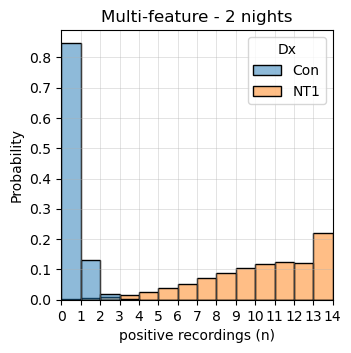

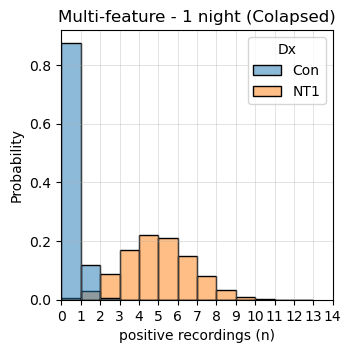

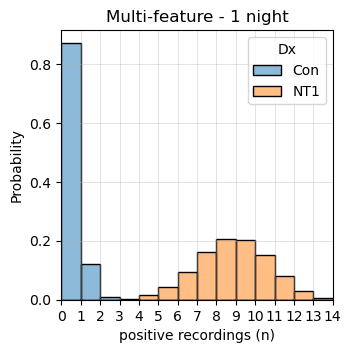

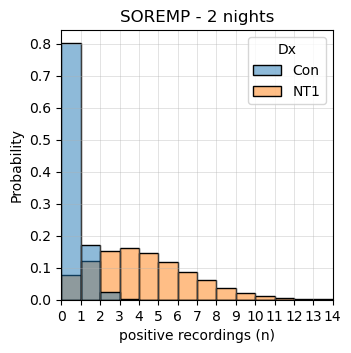

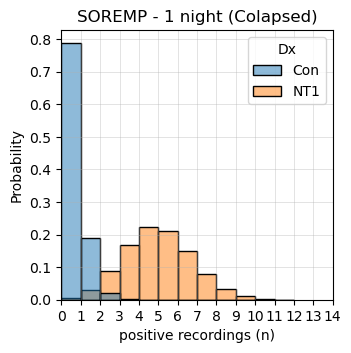

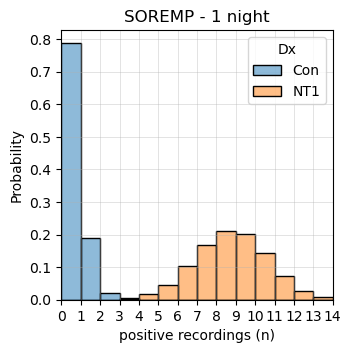

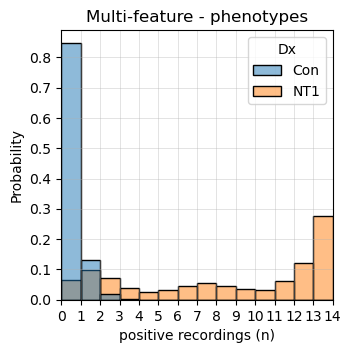

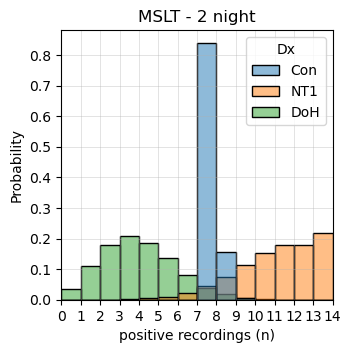

In [10]:
# Define parameters
realisations = 100000
prevalences = [1 / x for x in [2, 8, 32, 128, 512, 2048]]
nights = [0, 2, 4, 6, 9, 13]
nights = list(range(14))

#prevalences = ['1:128', '1:512', '1:2048']
min_PPVs = [2/3, 1/2, 1/3] # Corresponds to: FP:DP = [0.5, 1, 2] # FP:TP ratio
min_REs = [1/5, 1/4, 1/3, 1/2]
FP_TP_criterias = [1/pre - 1 for pre in min_PPVs]
hist_plot = True

results = []
#for com_datasets in tqdm(combined_datasets, total=len(combined_datasets), desc='Processing'):
for com_datasets in combined_datasets: # [:1]:
    
    # okay
    p = np.empty((0, len(nights)))
    y = np.empty(0)
    
    for dataset_dict_ in com_datasets['datasets']:
        
        # extract object
        dataset = dataset_dict_.get('dataset')
        R = dataset_dict_.get('R', realisations) 
        
        # extract p and y
        p_ = dataset.run_MCMC(realisations, N=nights) 
        p = np.concatenate((p, p_[:R, :]), axis=0) 
        y = np.concatenate((y, np.ones(R) * dx2idx[dataset.dx]), axis=0)
    
    if hist_plot: # plot hisogram
        # prep
        p_marg = p.sum(axis=1)
        df = pd.DataFrame({'Dx': y, 'positive recordings (n)': p_marg})
        df['Dx'] = df['Dx'].replace(idx2dx)
        
        # plot
        plot_histogram(data=df, x='positive recordings (n)', hue='Dx', hue_order=sort_by_dx_order(com_datasets['keys'].get('Dxs')),
                       title=com_datasets['keys'].get('name'), savedir=savedir)
        
    # compute metrics
    result = process_nights(y=y, p_full=p, nights=nights, prevalences=prevalences, min_PPVs=min_PPVs, min_REs=min_REs)
    
    # Add extra keys
    for r in result:
        r.update(com_datasets['keys']) # update - adds in place and returns None

    results += result
    
df_results = pd.DataFrame(results)
print(df_results.shape)
df_results.head()

In [11]:
df_results.to_csv(savedir / f"mcmc_analysis_{version}.csv", index=False)

#df_results.to_csv(savedir, f"{mcmc_analysis}.csv", index=False)

In [40]:
cols = ['name', 'Recordings (n)', 'Min. required positive (n)', 'Prevalence']
for col in cols: 
    print(f"{col}: {df_results[col].unique()}\n")


name: ['Multi-feature - 2 nights' 'Multi-feature - 1 night' 'SOREMP - 2 nights'
 'SOREMP - 1 night' 'PSG-based - 1 night - Stanford test'
 'Multi-feature - 1 night - Stanford test' 'Multi-feature - phenotypes']

Recordings (n): [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Min. required positive (n): [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Prevalence: ['1:2' '1:8' '1:32' '1:128' '1:512' '1:2048']



## Effect of multi-night

In [ ]:
"""
# TODO - Figure this out! effect of multi-night:

# sim = {'name': 'Wearable simulated - Stanford all - 1 rec', 'NT1_dataset': dataset_dict[6], 'Con_dataset': dataset_dict[7]}
sim = {'name': 'Wearable simulated\n994-0001, 994-1501, 861-2001', 'NT1_dataset': dataset_dict[20], 'Con_dataset': dataset_dict[13]}
# dataset
ds_nt1, ds_con = sim.get('NT1_dataset'), sim.get('Con_dataset')

# run mcmc
mcmc_nt1 = ds_nt1.run_MCMC(R=realisations, N=nights) #, overwrite=True)
mcmc_con = ds_con.run_MCMC(R=realisations, N=nights) #, overwrite=True)

for n in [1, 3, 7, 14]:    
    # plot histogram
    mcmc_nt1_marg, mcmc_con_marg = mcmc_nt1[:, :n].sum(axis=1), mcmc_con[:, :n].sum(axis=1)
    df = pd.DataFrame({ds_nt1.dx: mcmc_nt1_marg, ds_con.dx: mcmc_con_marg}).melt(value_name='positive nights (n)', var_name='Dx')
    plot_histogram(df, x='positive nights (n)', hue='Dx', hue_order=[ds_con.dx, ds_nt1.dx], figsize=(5, 4), version=version,
                   xlim=(0, n), title=f"Recordings: {n}")
"""
    

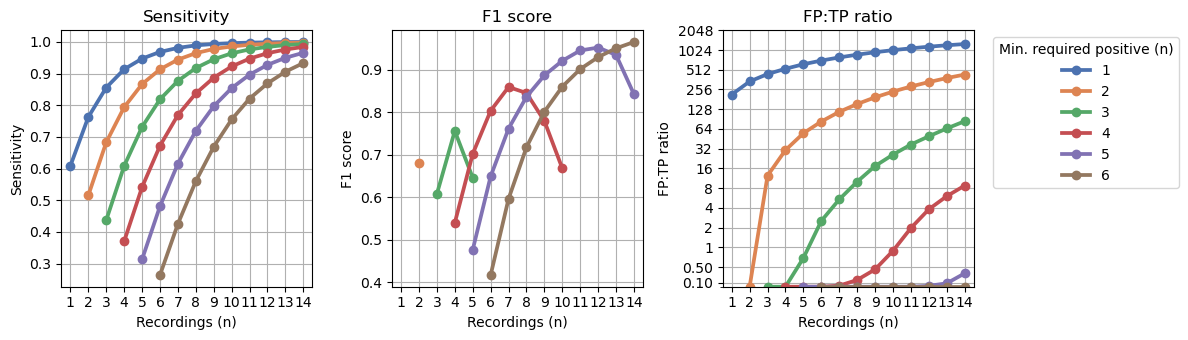

In [49]:
from matplotlib import pyplot as plt
import seaborn as sns

# select data
title = 'Wearable simulated\n994-0001, 994-1501, 861-2001'
min_req_nights = 6
min_PPV = 1/2
prevalence = '1:2048'
df_results_ = df_results[(df_results['Min. required positive (n)'] <= min_req_nights) & (df_results['title'] == title) & (df_results['Prevalence'] == prevalence) & (df_results['min PPV'] == min_PPV)]

# parameters
hue = 'Min. required positive (n)'
x = 'Recordings (n)'

# plot
fig, axes = plt.subplots(ncols=3, figsize=(12, 3.5))

# Sensitivity plot
sns.pointplot(df_results_, hue=hue, y='Sensitivity', x=x, palette='deep', ax=axes[0], ms=5)
axes[0].set_title('Sensitivity')
#axes[0].set_xlabel('Number of Days')
axes[0].set_ylabel('Sensitivity')
axes[0].grid(True)
axes[0].legend().remove()

# Specificity plot
sns.pointplot(df_results_, hue=hue, y='F1 score (min. PPV)', x=x, palette='deep', ax=axes[1], ms=5)
axes[1].set_title('F1 score')
#axes[1].set_xlabel('Number of Days')
axes[1].set_ylabel('F1 score')
axes[1].grid(True)
axes[1].legend().remove()

# FP:TP Ratio plot
sns.pointplot(df_results_, hue=hue, y='FP:TP', x=x, palette='deep', ax=axes[2], ms=5)
axes[2].set_title('FP:TP ratio')
#axes[2].set_xlabel('Number of Days')
axes[2].set_ylabel('FP:TP ratio')
axes[2].grid(True)
axes[2].legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')

# Customize y-tick labels to actual values
# ticks = [epsilon, 0.1, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256]
ticks = [0.1, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
axes[2].set_yscale('symlog', base=2, linthresh=1)  # Log scale with linear threshold near zero
axes[2].set_ylim([0, 2e3])
axes[2].set_yticks(ticks)
axes[2].set_yticklabels([f'{tick:.2f}' if tick < 1 else f'{tick}' for tick in ticks])  # Format values for readability

plt.tight_layout()
plt.show()

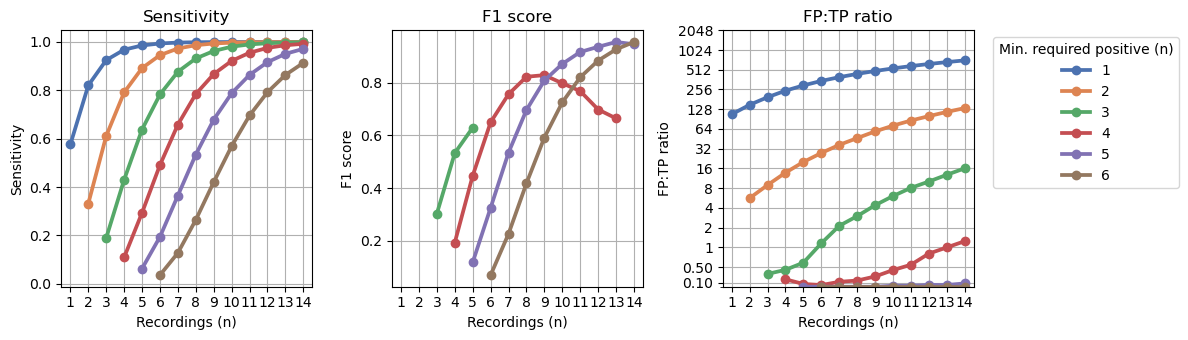

In [52]:
from matplotlib import pyplot as plt
import seaborn as sns

# select data
title = 'Wearable simulated\nStanford all - 1 rec'
min_req_nights = 6
min_PPV = 1/2
prevalence = '1:2048'
df_results_ = df_results[(df_results['Min. required positive (n)'] <= min_req_nights) & (df_results['title'] == title) & (df_results['Prevalence'] == prevalence) & (df_results['min PPV'] == min_PPV)]

# parameters
hue = 'Min. required positive (n)'
x = 'Recordings (n)'

# plot
fig, axes = plt.subplots(ncols=3, figsize=(12, 3.5))

# Sensitivity plot
sns.pointplot(df_results_, hue=hue, y='Sensitivity', x=x, palette='deep', ax=axes[0], ms=5)
axes[0].set_title('Sensitivity')
#axes[0].set_xlabel('Number of Days')
axes[0].set_ylabel('Sensitivity')
axes[0].grid(True)
axes[0].legend().remove()

# Specificity plot
sns.pointplot(df_results_, hue=hue, y='F1 score (min. PPV)', x=x, palette='deep', ax=axes[1], ms=5)
axes[1].set_title('F1 score')
#axes[1].set_xlabel('Number of Days')
axes[1].set_ylabel('F1 score')
axes[1].grid(True)
axes[1].legend().remove()

# FP:TP Ratio plot
sns.pointplot(df_results_, hue=hue, y='FP:TP', x=x, palette='deep', ax=axes[2], ms=5)
axes[2].set_title('FP:TP ratio')
#axes[2].set_xlabel('Number of Days')
axes[2].set_ylabel('FP:TP ratio')
axes[2].grid(True)
axes[2].legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')

# Customize y-tick labels to actual values
# ticks = [epsilon, 0.1, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256]
ticks = [0.1, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
axes[2].set_yscale('symlog', base=2, linthresh=1)  # Log scale with linear threshold near zero
axes[2].set_ylim([0, 2e3])
axes[2].set_yticks(ticks)
axes[2].set_yticklabels([f'{tick:.2f}' if tick < 1 else f'{tick}' for tick in ticks])  # Format values for readability

plt.tight_layout()
plt.show()

/var/folders/m_/cv6d9d7j7jbglrv6xhynzvrh0000gr/T/ipykernel_64130/2393524819.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')


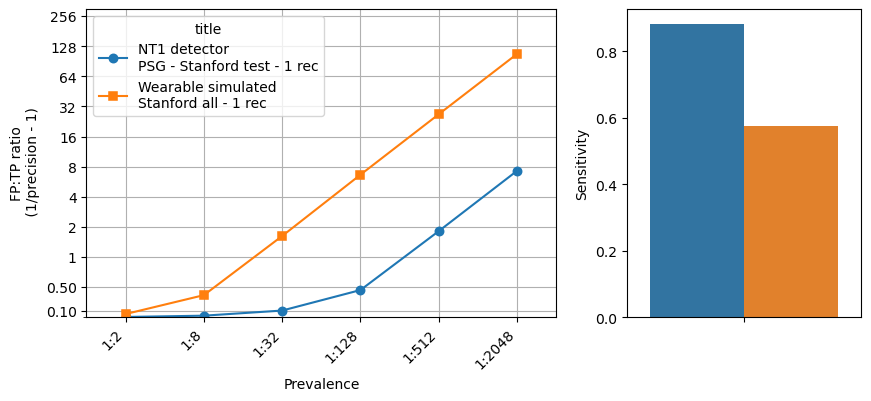

In [ ]:
# select data
titles = [
    'NT1 detector\nPSG - Stanford test - 1 rec', 
    'Wearable simulated\nStanford all - 1 rec'
]
recordings = 1 
df_results_ = df_results[df_results['title'].isin(titles) & (df_results['Recordings (n)'] == recordings)  & (df_results['min PPV'] == min_PPV)]

# parameters
epsilon = 1e-5

# plot
fig, ax = plt.subplots(ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})
sns.pointplot(
    df_results_,
    x='Prevalence', 
    y='FP:TP', 
    hue='title',
    markers=['o', 's', 'v', 'd', 'x'], ms=6,
    lw=1.5,
    ax=ax[0]
)

# Configurations
ax[0].set_ylabel('FP:TP ratio\n (1/precision - 1)')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')

# Set y-axis to log scale
#ax.set_yscale('symlog', base=2, linthresh=1e-2)  # Log scale with linear threshold near zero
ax[0].set_yscale('symlog', base=2, linthresh=1)  # Log scale with linear threshold near zero
ax[0].set_ylim([0, 300])

# Customize y-tick labels to actual values
ticks = [epsilon, 0.1, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256]
ticks = [0.1, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256]
ax[0].set_yticks(ticks)
ax[0].set_yticklabels([f'{tick:.2f}' if tick < 1 else f'{tick}' for tick in ticks])  # Format values for readability

# final
ax[0].grid()

sns.barplot(df_results_, hue='title', y='Sensitivity', ax=ax[1])
ax[1].legend().remove()


In [15]:
df_results[(df_results['Recordings (n)'] == recordings) & (df_results['Min. required positive (n)'] == min_req_nights)].head()

,title,Recordings (n),Min. required positive (n),Prevalence,Sensitivity,Specificity,PPV,FP:TP,TN,FP,FN,TP


/var/folders/m_/cv6d9d7j7jbglrv6xhynzvrh0000gr/T/ipykernel_64130/143651078.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')


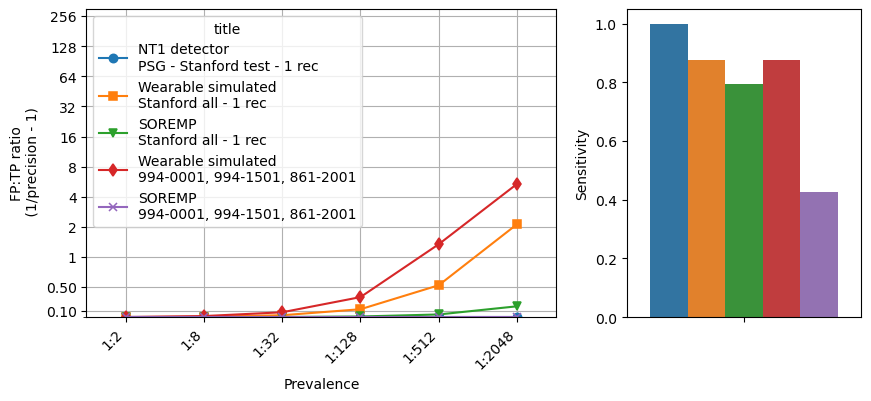

In [ ]:

# select data
titles = [
    'NT1 detector\nPSG - Stanford test - 1 rec',
    'Wearable simulated\nStanford all - 1 rec',
    'SOREMP\nStanford all - 1 rec',
    'Wearable simulated\n994-0001, 994-1501, 861-2001',
    'SOREMP\n994-0001, 994-1501, 861-2001',
    #'Wearable simulated\nclinical trial NT1s vs. Stanford (NSRR) Controls',
    #'SOREMP\nclinical trial NT1s vs. Stanford (NSRR) Controls',
    #'MLST\nMSLT combined NT1s vs. Stanford (NSRR) controls',
    #'MSLT\nNT1s vs. DoH - 2 recs',
]
min_req_nights = 3
recordings = 7
min_PPV = 1/2
df_results_ = df_results[df_results['title'].isin(titles) & (df_results['Recordings (n)'] == recordings) & (df_results['Min. required positive (n)'] == min_req_nights) & (df_results['min PPV'] == min_PPV)]

# parameters
epsilon = 1e-5

# plot
fig, ax = plt.subplots(ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})
sns.pointplot(
    df_results_,
    x='Prevalence', 
    y='FP:TP', 
    hue='title', 
    markers=['o', 's', 'v', 'd', 'x'], ms=6,
    lw=1.5,
    ax=ax[0]
)

# Configurations
ax[0].set_ylabel('FP:TP ratio\n (1/precision - 1)')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')

# Set y-axis to log scale
#ax.set_yscale('symlog', base=2, linthresh=1e-2)  # Log scale with linear threshold near zero
ax[0].set_yscale('symlog', base=2, linthresh=1)  # Log scale with linear threshold near zero
ax[0].set_ylim([0, 300])

# Customize y-tick labels to actual values
ticks = [epsilon, 0.1, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256]
ticks = [0.1, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256]
ax[0].set_yticks(ticks)
ax[0].set_yticklabels([f'{tick:.2f}' if tick < 1 else f'{tick}' for tick in ticks])  # Format values for readability

# final
ax[0].grid()

sns.barplot(df_results_, hue='title', y='Sensitivity', ax=ax[1])
ax[1].legend().remove()

In [63]:
df_results_[df_results_['Prevalence'] == '1:2048'].head()

,title,Recordings (n),Min. required positive (n),Prevalence,min PPV,Sensitivity,Specificity,PPV,FP:TP,F1 score,F1 score (min. PPV),TN,FP,FN,TP
430,NT1 detector\nPSG - Stanford test - 1 rec,7,3,1:2048,0.5,0.99966,1.00000,1.000000,0.000000,0.999830,0.999830,199902.343750,0.000000,0.033203,97.623047
2320,Wearable simulated\nStanford all - 1 rec,7,3,1:2048,0.5,0.87689,0.99909,0.320073,2.124292,0.468968,NaN,199720.432617,181.911133,12.022461,85.633789
4210,SOREMP\nStanford all - 1 rec,7,3,1:2048,0.5,0.79330,0.99993,0.847009,0.180625,0.819275,0.819275,199888.350586,13.993164,20.185547,77.470703
6100,"Wearable simulated\n994-0001, 994-1501, 861-2001",7,3,1:2048,0.5,0.87657,0.99770,0.156960,5.371049,0.266246,NaN,199442.568359,459.775391,12.053711,85.602539
7990,"SOREMP\n994-0001, 994-1501, 861-2001",7,3,1:2048,0.5,0.42613,1.00000,1.000000,0.000000,0.597603,0.597603,199902.343750,0.000000,56.041992,41.614258


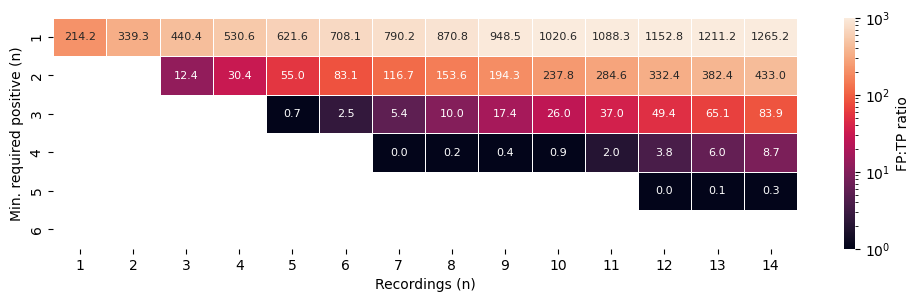

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm

# select data
title = 'Wearable simulated\n994-0001, 994-1501, 861-2001'
min_req_nights = 6
min_PPV = 1/2
prevalence = '1:2048'
df_results_ = df_results[(df_results['Min. required positive (n)'] <= min_req_nights) & (df_results['title'] == title) & (df_results['Prevalence'] == prevalence) & (df_results['min PPV'] == min_PPV)]

# Plot
hue = 'Min. required positive (n)'
x = 'Recordings (n)'
y = 'FP:TP'
data = (df_results_.pivot(index=hue, columns=x, values=y))

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(12, 3))
sns.heatmap(
    data, 
    annot=True, 
    fmt=".1f", 
    linewidths=.5, 
    ax=ax, 
    vmin=0, 
    vmax=1000, 
    norm=LogNorm(vmin=1, vmax=1000), 
    annot_kws={"size": 8}
)
cb = ax.collections[0].colorbar
cb.set_label('FP:TP ratio')

# you have prevalence too! 

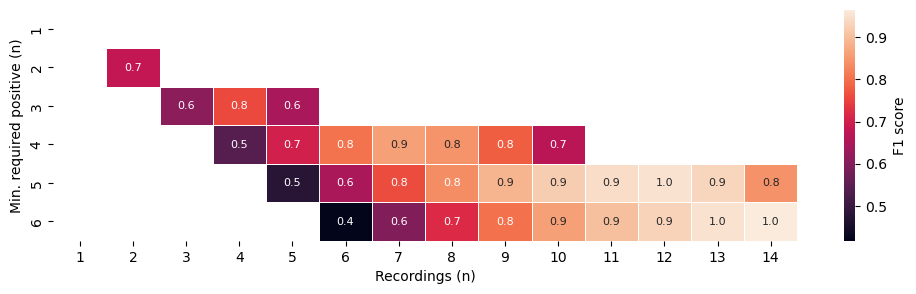

In [66]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm

# select data
title = 'Wearable simulated\n994-0001, 994-1501, 861-2001'
min_req_nights = 6
min_PPV = 1/2
prevalence = '1:2048'
df_results_ = df_results[(df_results['Min. required positive (n)'] <= min_req_nights) & (df_results['title'] == title) & (df_results['Prevalence'] == prevalence) & (df_results['min PPV'] == min_PPV)]

# Plot
hue = 'Min. required positive (n)'
x = 'Recordings (n)'
y = 'F1 score (min. PPV)'
data = (df_results_.pivot(index=hue, columns=x, values=y))

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(12, 3))
sns.heatmap(
    data, 
    annot=True, 
    fmt=".1f", 
    linewidths=.5, 
    ax=ax, 
    #vmin=0, 
    #vmax=1, 
    #norm=LogNorm(vmin=1, vmax=1000), 
    annot_kws={"size": 8}
)
cb = ax.collections[0].colorbar
cb.set_label('F1 score')

# you have prevalence too! 

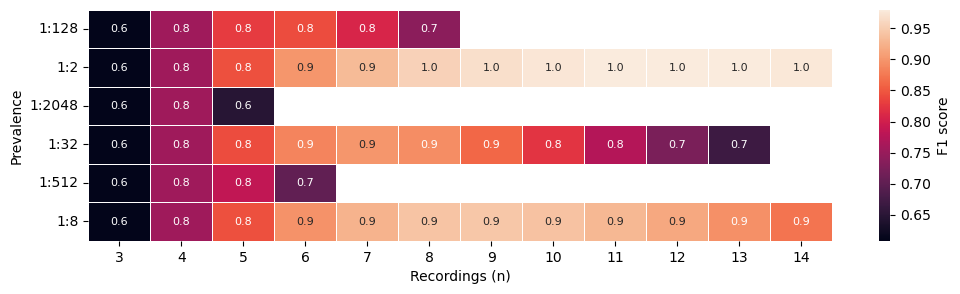

In [68]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm

# select data
title = 'Wearable simulated\n994-0001, 994-1501, 861-2001'
min_req_nights = 3
min_PPV = 1/2
#prevalence = '1:2048'
#min_req_nights = 3
df_results_ = df_results[(df_results['Min. required positive (n)'] == min_req_nights) & (df_results['title'] == title) & (df_results['min PPV'] == min_PPV)]

# Plot
hue = 'Prevalence'
x = 'Recordings (n)'
y = 'F1 score (min. PPV)'
data = (df_results_.pivot(index=hue, columns=x, values=y))

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(12, 3))
sns.heatmap(
    data, 
    annot=True, 
    fmt=".1f", 
    linewidths=.5, 
    ax=ax, 
    #vmin=0, 
    #vmax=1, 
    #norm=LogNorm(vmin=1, vmax=1000), 
    annot_kws={"size": 8}
)
cb = ax.collections[0].colorbar
cb.set_label('F1 score')

# you have prevalence too! 

In [ ]:
# next step - what is it?! ?! ?! 

# try prevalences: 
prevalences = ['1:128', '1:512', '1:2048']
min_precisions = [4/5, 1/2, 1/3]
# FP_TP_criterias = [1/pre - 1 for pre in precision]

# what do you want the plot to look like: 
# y = sensitivity, only display sensitivities for valid FP:TP ratios. You enforce a minimum FP:TP ratio first. 
# cols = prevalence (test for 3 prevalences only)
# x = # recordings
# hue = titles.

# I still need to plot FP:TP ratio on second y axis...
# first y-axis is sensitivity, second y-axis is bar-plot of FP:TP ratio.

# select data 
titles = [
    #'NT1 detector\nPSG - Stanford test - 1 rec',
    #'Wearable simulated\nStanford all - 1 rec',
    #'SOREMP\nStanford all - 1 rec',
    'Wearable simulated\n994-0001, 994-1501, 861-2001',
    #'SOREMP\n994-0001, 994-1501, 861-2001',
    #'Wearable simulated\nclinical trial NT1s vs. Stanford (NSRR) Controls',
    #'SOREMP\nclinical trial NT1s vs. Stanford (NSRR) Controls',
    #'MLST\nMSLT combined NT1s vs. Stanford (NSRR) controls',
    #'MSLT\nNT1s vs. DoH - 2 recs'
]

df_out = []
for min_precision in min_precisions: 
    for title in titles:
        for prevalence in prevalences:
            for night in nights:
                
                # select data:
                df_ = df_results[
                    (df_results['title'] == title) & 
                    (df_results['Recordings (n)'] == (night + 1)) & 
                    (df_results['Prevalence'] == prevalence) &
                    (df_results['min PPV'] == min_precision)
                ]
                
                # select max 'f1 score (min. PPV)'
                #df_ = df_.sort_values(by='F1 score (min. PPV)', ascending=False).head(1)
                df_sorted = df_.sort_values(by='F1 score (min. PPV)', ascending=False).head(1)
                if not df_sorted.empty:
                    df_dict = df_sorted.iloc[0].to_dict()
                    if df_dict['F1 score (min. PPV)'] > 0:
                        df_out.append(df_dict)
                

df_selected = pd.DataFrame(df_out)

cols = ['title', 'Recordings (n)', 'Min. required positive (n)', 'Prevalence', 'min PPV']
for col in cols: 
    print(f"{col}: {df_selected[col].unique()}\n")
print(df_selected.shape)
df_selected.head(10)



title: ['Wearable simulated\nStanford all - 1 rec'
 'Wearable simulated\n994-0001, 994-1501, 861-2001']

Recordings (n): [ 3  4  5  6  7  8  9 10 11 12 13 14  2]

Min. required positive (n): [3 4 5 6 2]

Prevalence: ['1:128' '1:512' '1:2048']

min PPV: [0.8        0.5        0.33333333]

(227, 15)


,title,Recordings (n),Min. required positive (n),Prevalence,min PPV,Sensitivity,Specificity,PPV,FP:TP,F1 score,F1 score (min. PPV),TN,FP,FN,TP
0,Wearable simulated\nStanford all - 1 rec,3,3,1:128,0.8,0.19078,0.99997,0.980420,0.019971,0.319407,0.319407,198431.546875,5.953125,1264.406250,298.093750
1,Wearable simulated\nStanford all - 1 rec,4,3,1:128,0.8,0.43415,0.99982,0.949979,0.052655,0.595946,0.595946,198401.781250,35.718750,884.140625,678.359375
2,Wearable simulated\nStanford all - 1 rec,5,3,1:128,0.8,0.64151,0.99968,0.940424,0.063351,0.762726,0.762726,198374.000000,63.500000,560.140625,1002.359375
3,Wearable simulated\nStanford all - 1 rec,6,3,1:128,0.8,0.78691,0.99942,0.914406,0.093607,0.845881,0.845881,198322.406250,115.093750,332.953125,1229.546875
4,Wearable simulated\nStanford all - 1 rec,7,3,1:128,0.8,0.87839,0.99911,0.885992,0.128679,0.882175,0.882175,198260.890625,176.609375,190.015625,1372.484375
5,Wearable simulated\nStanford all - 1 rec,8,3,1:128,0.8,0.93271,0.99870,0.849610,0.177011,0.889223,0.889223,198179.531250,257.968750,105.140625,1457.359375
6,Wearable simulated\nStanford all - 1 rec,9,4,1:128,0.8,0.87159,0.99990,0.985638,0.014571,0.925112,0.925112,198417.656250,19.843750,200.640625,1361.859375
7,Wearable simulated\nStanford all - 1 rec,10,4,1:128,0.8,0.92511,0.99985,0.979823,0.020592,0.951681,0.951681,198407.734375,29.765625,117.015625,1445.484375
8,Wearable simulated\nStanford all - 1 rec,11,4,1:128,0.8,0.95648,0.99980,0.974131,0.026556,0.965225,0.965225,198397.812500,39.687500,68.000000,1494.500000
9,Wearable simulated\nStanford all - 1 rec,12,4,1:128,0.8,0.97606,0.99973,0.966061,0.035131,0.971035,0.971035,198383.921875,53.578125,37.406250,1525.093750


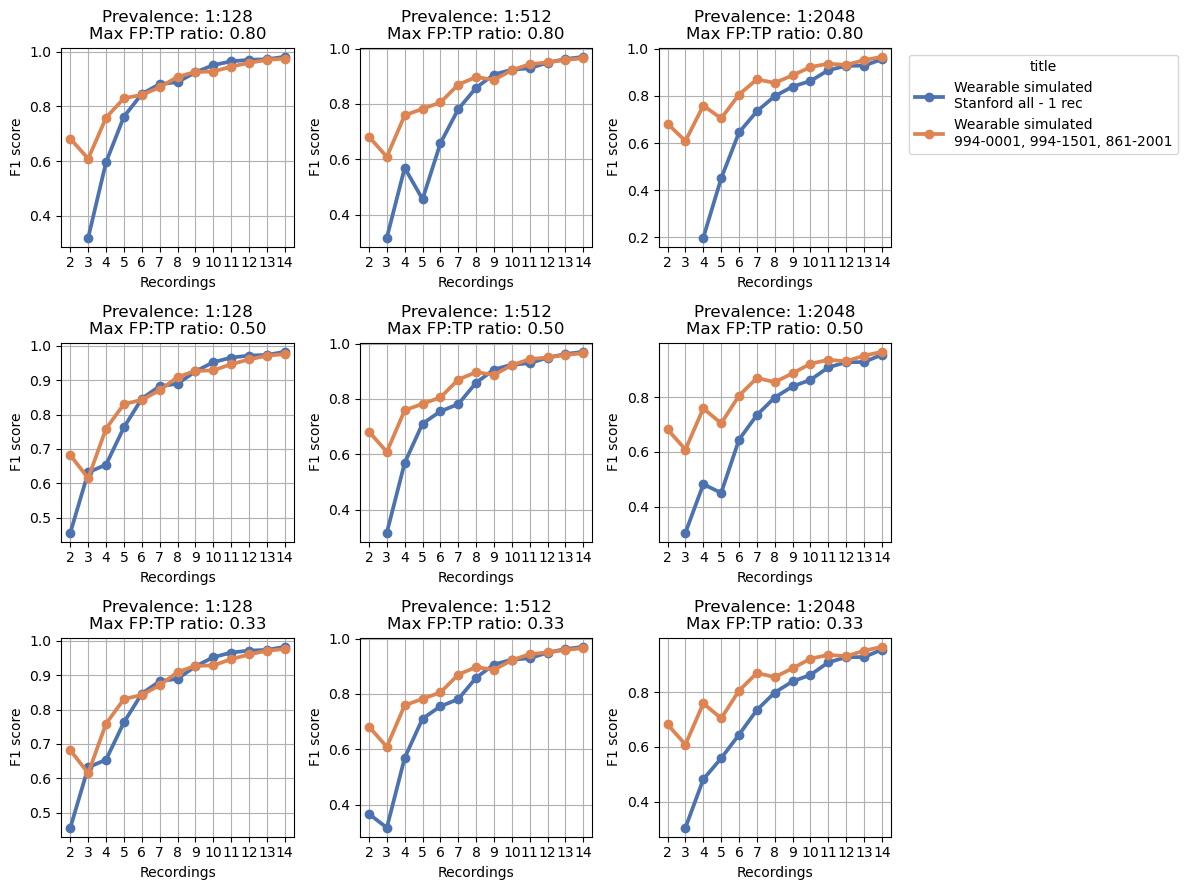

In [26]:
# now plot 


# select data:
# df_selected[df_selected['title'] == 'NT1 detector\nPSG - Stanford test - 1 rec']
x = 'Recordings (n)'
cols = 'Prevalence'
rows = 'min PPV'
y = 'F1 score'
hue = 'title'

# plot
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 9))

for i, min_precision in enumerate(min_precisions):
    for j, prevalence in enumerate(prevalences):
        
        # select data:
        df_ = df_selected[
            (df_selected['Prevalence'] == prevalence) & 
            (df_selected['min PPV'] == min_precision)
        ]
        
        # plot
        sns.pointplot(df_, x=x, y=y, hue=hue, ax=axes[i, j], palette='deep', ms=5, hue_order=titles)

        # set titles and labels
        axes[i, j].set_title(f"Prevalence: {prevalence}\nMax FP:TP ratio: {min_precision:.2f}")
        axes[i, j].set_ylabel('F1 score')
        axes[i, j].set_xlabel('Recordings')
        axes[i, j].grid(True)
        
        # remove legends to avoid duplication
        axes[i, j].legend().remove()

axes[0, 2].legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

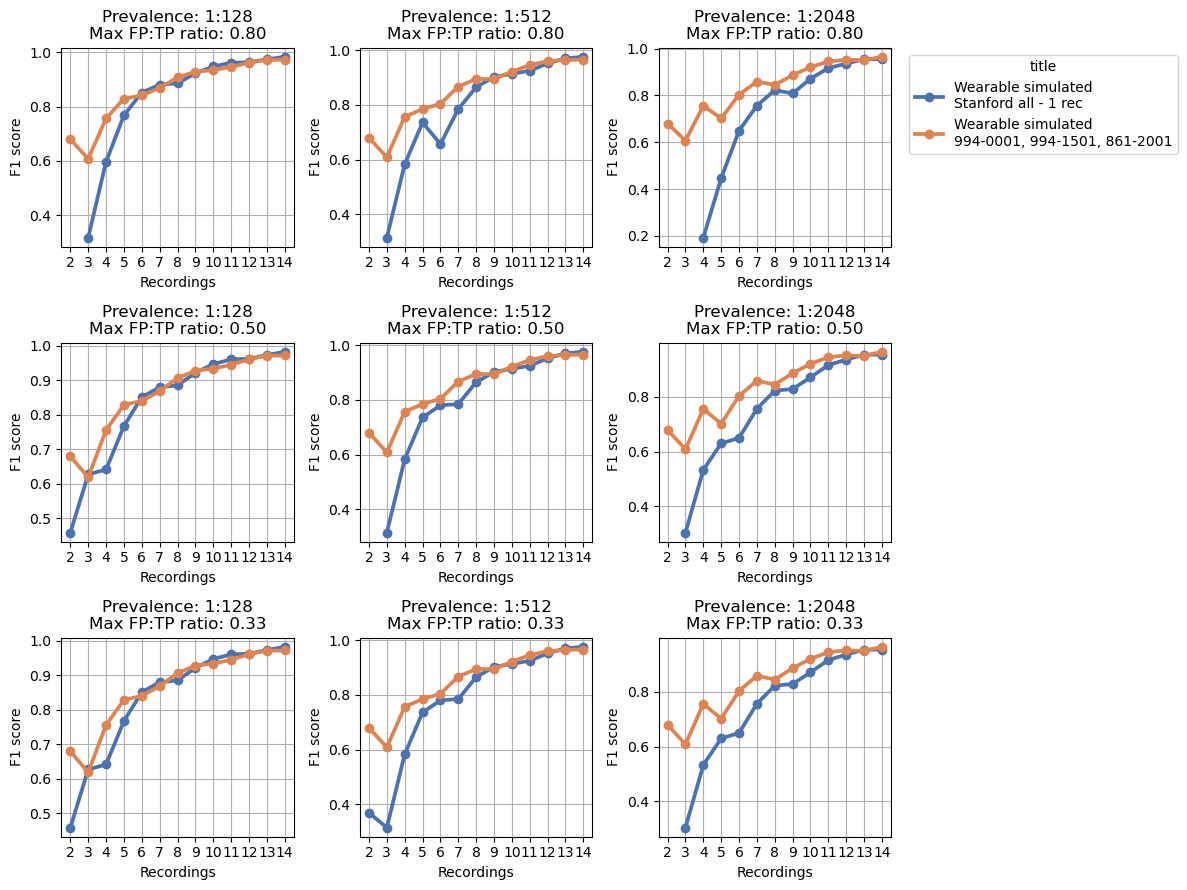

In [ ]:
# now plot 


# select data:
# df_selected[df_selected['title'] == 'NT1 detector\nPSG - Stanford test - 1 rec']
x = 'Recordings (n)'
cols = 'Prevalence'
rows = 'min PPV'
y = 'F1 score'
hue = 'title'

# plot
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 9))

for i, min_precision in enumerate(min_precisions):
    for j, prevalence in enumerate(prevalences):
        
        # select data:
        df_ = df_selected[
            (df_selected['Prevalence'] == prevalence) & 
            (df_selected['min PPV'] == min_precision)
        ]
        
        # plot
        sns.pointplot(df_, x=x, y=y, hue=hue, ax=axes[i, j], palette='deep', ms=5, hue_order=titles)

        # set titles and labels
        axes[i, j].set_title(f"Prevalence: {prevalence}\nMax FP:TP ratio: {min_precision:.2f}")
        axes[i, j].set_ylabel('F1 score')
        axes[i, j].set_xlabel('Recordings')
        axes[i, j].grid(True)
        
        # remove legends to avoid duplication
        axes[i, j].legend().remove()

axes[0, 2].legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# compare 1st

# du er done - no more variables - just net this! 

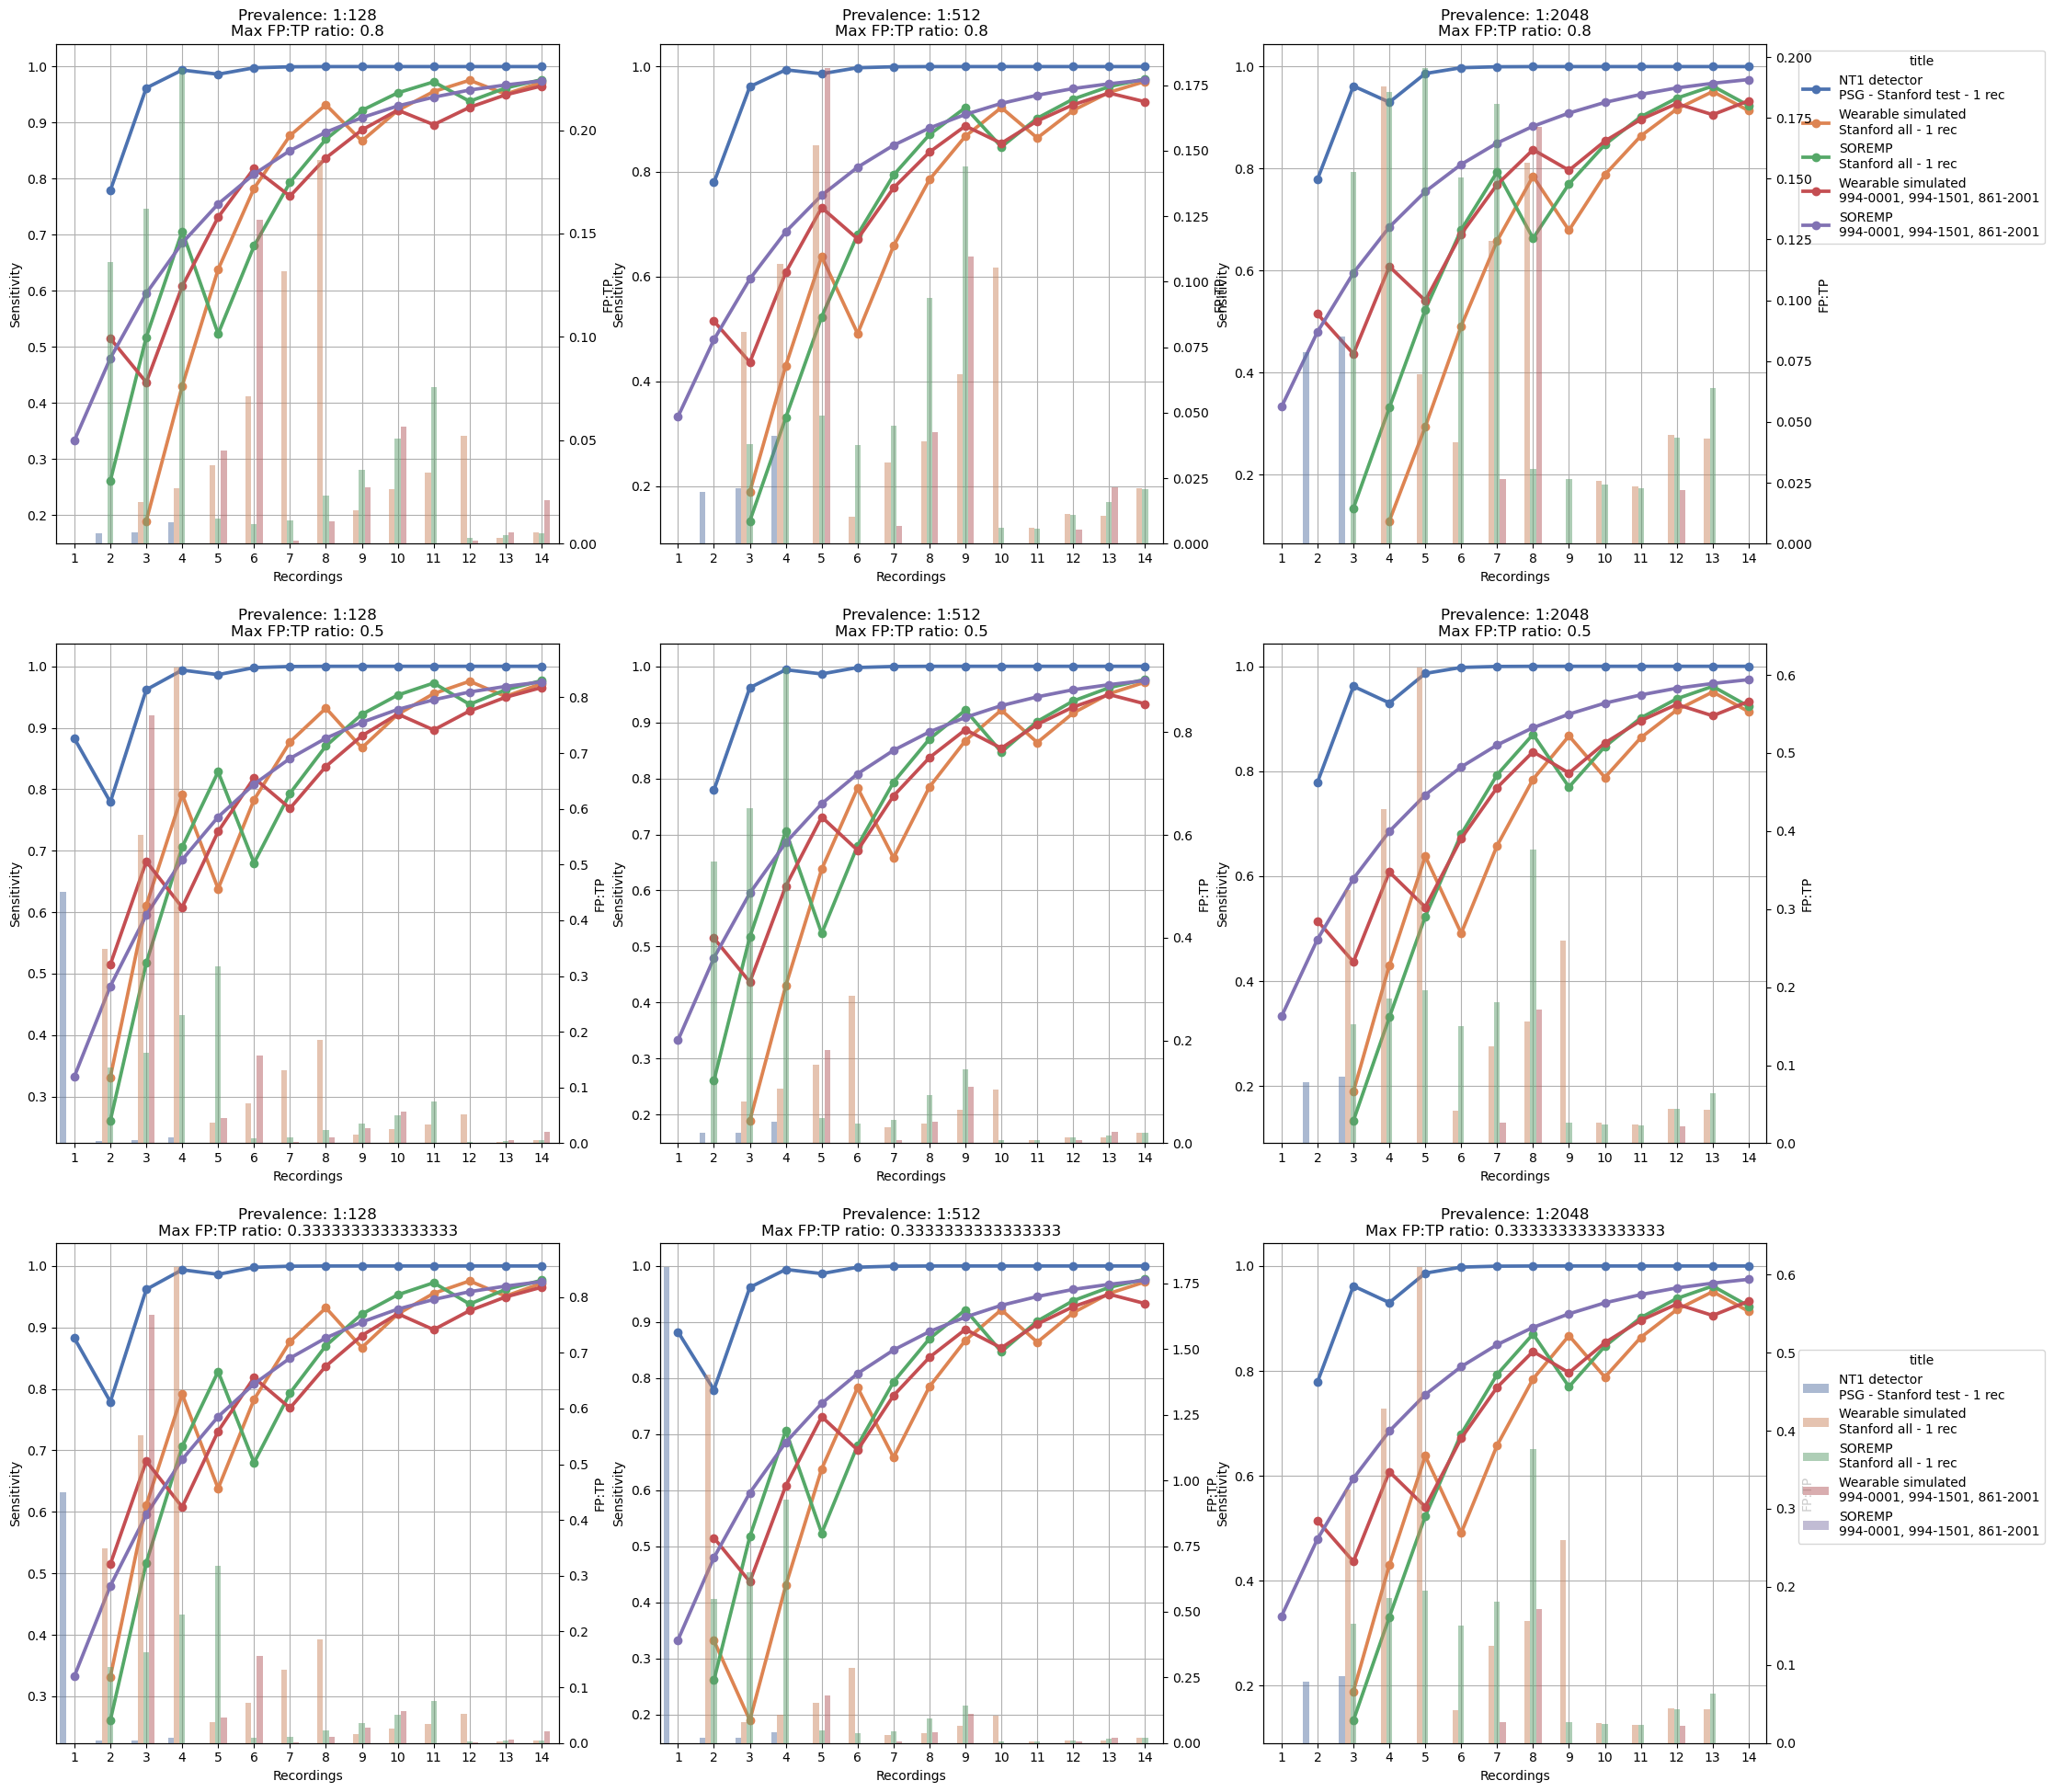

In [81]:
# now plot 



# select data:
# df_selected[df_selected['title'] == 'NT1 detector\nPSG - Stanford test - 1 rec']
x = 'Recordings (n)'
cols = 'Prevalence'
rows = 'min PPV'
y = 'Sensitivity'
hue = 'title'
yy= 'FP:TP' # bar plot

# plot
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(24, 24))

for i, min_precision in enumerate(min_precisions):
    for j, prevalence in enumerate(prevalences):
        
        # select data:
        df_ = df_selected[
            (df_selected['Prevalence'] == prevalence) & 
            (df_selected['min PPV'] == min_precision)
        ]
        
        # plot
        sns.pointplot(df_, x=x, y=y, hue=hue, ax=axes[i, j], palette='deep', ms=5, hue_order=titles)

        # 
        ax2 = axes[i, j].twinx()

        # plot bar plot on secondary y-axis
        sns.barplot(data=df_, x=x, y=yy, hue=hue, ax=ax2, palette='deep', alpha=0.5, hue_order=titles)
        
        # set titles and labels
        axes[i, j].set_title(f"Prevalence: {prevalence}\nMax FP:TP ratio: {min_precision}")
        axes[i, j].set_ylabel('Sensitivity')
        axes[i, j].set_xlabel('Recordings')
        axes[i, j].grid(True)
        
        # remove legends to avoid duplication
        axes[i, j].legend().remove()
        ax2.legend().remove()

axes[0, 2].legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title=hue, bbox_to_anchor=(1.05, 0.8), loc='upper left')

# plt.tight_layout()
plt.show()